In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Loading Dataset

- The dataset being used is tweet's sentiment dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and can be used to detect sentiment.

In [149]:
cols  = ["Sentiment", "Id", "Date", "Flag", "User", "Text"]

In [150]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin1', names = cols)

In [151]:
df.head()

,Sentiment,Id,Date,Flag,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Sentiment  1600000 non-null  int64 
 1   Id         1600000 non-null  int64 
 2   Date       1600000 non-null  object
 3   Flag       1600000 non-null  object
 4   User       1600000 non-null  object
 5   Text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


# Checking Duplicated or Missing values

In [153]:
df.duplicated().sum()

0

In [154]:
df.isna().sum()

Sentiment    0
Id           0
Date         0
Flag         0
User         0
Text         0
dtype: int64

# Keeping only Required Columns

In [155]:
df.drop(columns=['Id', 'Date', 'Flag', 'User'], inplace=True)

- Currently in Target Column, '0' is referred as negative & '4' as Positive. Hence, Converting this to : '0' as Negative And '1' as Positive

In [156]:
df['Sentiment'] = df['Sentiment'].map({0:0,4:1})

In [157]:
df['Sentiment'].value_counts()

1    800000
0    800000
Name: Sentiment, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


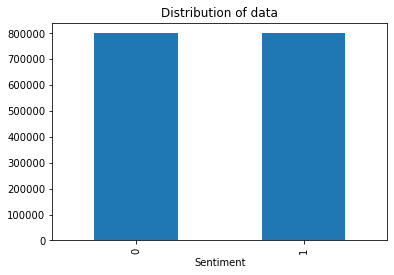

In [158]:
print(df.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data', legend=False))

# Text Preprocessing

In [159]:
import re
from wordcloud import WordCloud

## Converting text to Lower case

In [160]:
df['Text'] = df['Text'].apply(lambda x: x.lower())

In [161]:
df['Text']

0          @switchfoot http://twitpic.com/2y1zl - awww, t...
1          is upset that he can't update his facebook by ...
2          @kenichan i dived many times for the ball. man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: Text, Length: 1600000, dtype: object

## Converting Regular expression & emoji to text

In [162]:
# dictionary containing all emojis & their meanings

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [163]:
# dictionary containing negative short-form

neg_contractions = {"ain't": 'am not', "aren't": 'are not', 'cannot': 'can not', "can't": 'can not',"can't've": 'can not have',
                    "oughtn't": 'ought not', "wasn't": 'was not', "shan't've": 'shall not have', "shouldn't": 'should not',
                    "wouldn": 'would not', "wouldn't": 'would not', "oughtn't've": 'ought not have', "shan't": 'shall not',
                    "couldn't": 'could not', "couldn't've": 'could not have', "didn't": 'did not', "didn": 'did not',
                    "doesn't": 'does not', "needn't": 'need not', "needn": 'need not', "needn't've": 'need not have',
                    "shouldn't've": 'should not have', "don't": 'do not', "hadn't": 'had not', "hadn": 'had not',
                    "hadn't've": 'had not have', "hasn't": 'has not', "hasn": 'has not', "haven't": 'have not',
                    "haven": 'have not', "isn't": 'is not', "mayn't": 'may not', "mightn't": 'might not', 
                    "mightn't've": 'might not have', "mustn't": 'must not', "mustn't've": 'must not have',
                    "sha'n't": 'shall not'}

In [164]:
# Regex patterns

url_Pattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
user_Pattern       = '@[^\s]+'
Hashtag_Pattern    = '#[^\s]+'

In [165]:
def regex_processing(txt_data):
    processed_txt = []

    for txt in txt_data:

        for emoji in emojis.keys():
            txt = txt.replace(emoji, "EMOJI" + emojis[emoji])        
        
        for contrac in neg_contractions.keys():
            txt = txt.replace(contrac, neg_contractions[contrac])            
        
        txt = re.sub(url_Pattern,'',txt)

        txt = re.sub(user_Pattern,'',txt)

        txt = re.sub(Hashtag_Pattern,'', txt)        
        
        processed_txt.append(txt)

    return processed_txt

In [166]:
## Removing Regex from string

processed_txt = regex_processing(df['Text'])

In [167]:
processed_txt[:4]

["  - awww, that's a bummer.  you shoulda got david carr of third day to do it. EMOJIwink",
 'is upset that he can not update his facebook by texting it... and might cry as a result  school today also. blah!',
 ' i dived many times for the ball. managed to save 50%  the rest go out of bounds',
 'my whole body feels itchy and like its on fire ']

## further cleaning

- Lemmatize, Removing Stopwords & Punctuations

In [168]:
import string

import spacy
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [169]:
# to remove punctuations from the text

punc = set(string.punctuation)
print(punc)

{'%', '^', '`', '>', "'", '#', '.', '~', ']', '<', '"', '+', '(', '-', '=', '[', '!', '@', '\\', '_', '{', ':', '&', '/', ',', '$', '}', '*', '?', ';', '|', ')'}


In [170]:
# ' '.join([i for i in Tweettokenizer.tokenize(" taylor 814ce --&gt; #&amp;$(#&amp;$!( sweet mother of # only 2900 that's")])

- Making a complete set of all Stop Words

In [171]:
from nltk.corpus import stopwords
from stop_words import get_stop_words
from spacy.lang.en.stop_words import STOP_WORDS

In [172]:
# Stopwords in Stop_words Library
stop_words = set(get_stop_words('english'))

print('Stopwords in Stop_words : {}'.format(len(stop_words)))

Stopwords in Stop_words : 174


In [173]:
# Stopwords in Spacy
Spacy_STOP_WORDS = set(STOP_WORDS)

print('Stopwords in Spacy : {}'.format(len(Spacy_STOP_WORDS)))

Stopwords in Spacy : 326


In [174]:
# Stopwords in NLTK
nltk_stopwords = set(stopwords.words('english'))

print('Stopwords in NLTK : {}'.format(len(nltk_stopwords)))

Stopwords in NLTK : 179


In [175]:
stopwords_contractions = {"'cause", "could've", "he'd", "he'd've", "he'll", "he'll've", "he's", "how'd", "how'd'y", "how'll",
                          "how's", "i'd", "i'd've", "i'll", "i'll've", "i'm", "i've", "it'd", "it'd've", "it'll", "it'll've",
                          "should've", "so've", "so's", "that'd", "that'd've", "that's", "there'd", "there'd've", "there's",
                          "they'd", "they'd've", "they'll", "they'll've", "they're", "they've", "to've", "it's", "let's",
                          "might've", "must've", "she'd", "she'd've", "she'll", "she'll've", "she's", ' u ', ' ur ', ' n '}

len(stopwords_contractions)

49

In [176]:
stop_words = set({})

stop_words.update(nltk_stopwords)
stop_words.update(Spacy_STOP_WORDS)
stop_words.update(stopwords_contractions)

len(stop_words)

428

In [177]:
# removing Negative Stopwords to make model learn '+ve' & '-ve' sentiment  more accurately

stop_words = set([i for i in stop_words if "n't" not in i])

neg_stpwrds = ['without', 'why', 'please', 'enough', 'empty', 'alone', 'against', 'no', 'not', 'never', 'none', 'nor', 'neither', 'nobody', 'nothing', 'neither', 'nowhere']

stop_words.remove('won')

for i in neg_stpwrds:
    if i in stop_words:
        stop_words.remove(i)

In [178]:
len(stop_words)

392

- Using WordNetLemmatizer to get root word

In [179]:
# Using WordNetLemmatizer, TweetTokenizer by NLTK

lemmatizer = WordNetLemmatizer()
Tweettokenizer = TweetTokenizer()

In [180]:
# Using Spacy to Lemmatize words

nlp = spacy.load('en_core_web_sm')

In [181]:
# To replace 3 or more consecutive letters by 1 letter

sequence_Pattern   = r"(.)\1\1+"
seqReplace_Pattern = r"\1"

In [182]:
# Text cleaning Using NLTK

def text_cleaning(txt_data):
    clean_data = []

    for txt in txt_data:
        # replace 3 or more consecutive letters by 1 letter
        txt = re.sub(sequence_Pattern, seqReplace_Pattern, txt)
        
        # Lemmatizing words using NLTK
        tweet = ''
        for i in Tweettokenizer.tokenize(txt):
            if len(i)>1:
                i = lemmatizer.lemmatize(i)
                tweet += (i+' ')
        
        # Removing Stop words
        tweet_text = ' '.join([i for i in tweet.split() if i not in stop_words])
        
        # Removing Punctuations
        for i in tweet_text:
            if i in punc:
                tweet_text = tweet_text.replace(i,'')

        clean_data.append(tweet_text)

    return clean_data

- Text Cleaning Using **Spacy**

def text_cleaning(txt_data):
    clean_data = []

    for txt in txt_data:
        # replace 3 or more consecutive letters by 1 letter
        txt = re.sub(sequence_Pattern, seqReplace_Pattern, txt)
        
        # Lemmatizing using Spacy.
        txt_list = nlp(txt)
        tweet = ' '.join([i.lemma_.lower() for i in txt_list])
        
        # Removing Stop words
        tweet_txt = ' '.join([i for i in tweet.split() if i not in stop_words])
        
        # Removing Punctuations
        for i in tweet_txt:
            if i in punc:
                tweet_txt = tweet_txt.replace(i,'')

        clean_data.append(tweet_txt)

    return clean_data

In [183]:
# Using NLTK Lemmatizer to clean the data as Spacy's Lemmatizer takes more time to run
# To compare - first 1000 tweets processed by Spacy in 3.91 sec whereas NLTK took 101 ms only.

clean_data = text_cleaning(processed_txt)

In [184]:
clean_data[:4]

['aw bummer shoulda got david carr day EMOJIwink',
 'upset not update facebook texting cry result school today blah',
 'dived time ball managed save 50 rest bound',
 'body feel itchy like fire']

## Analysing the data

### Ploting **Word Clouds** for **Positive and Negative** tweets to check which word occur the most

- WordCloud for **Negative tweets**

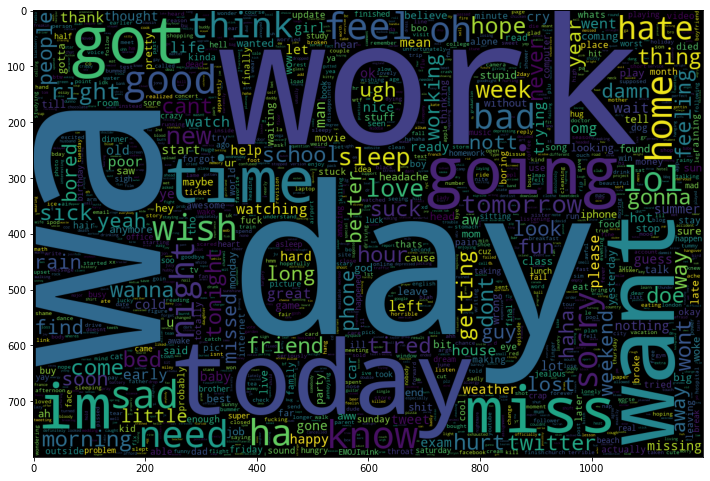

In [185]:
# Since first 800000 tweets are Negative, I am using '[:800000]' to visualize words used in Negative tweet

plt.figure(figsize = (12,9))

neg_tweet = clean_data[:800000]
wc = WordCloud(max_words = 1600 , width = 1200 , height = 800, collocations=False).generate(" ".join(neg_tweet))

plt.imshow(wc)

- WordCloud for **Positive tweets**

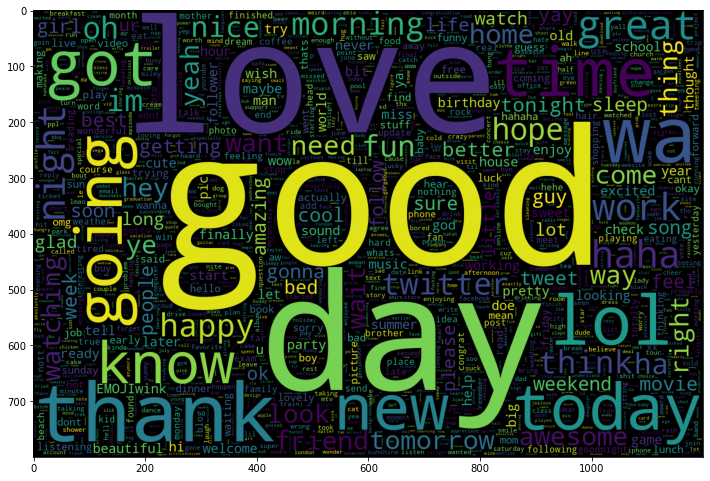

In [186]:
plt.figure(figsize = (12,9))

pos_tweet = clean_data[800000:]
wc = WordCloud(max_words = 1600 , width = 1200 , height = 800, collocations=False).generate(" ".join(pos_tweet))

plt.imshow(wc)

# Splitting the Data


In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [188]:
x = clean_data
y = df['Sentiment']

In [189]:
# splitting train & test set in ratio 9:1 respectively.

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 123, stratify = y)

# TF-IDF Vectoriser

In [190]:
vectoriser = TfidfVectorizer(ngram_range=(1,8), max_features=800000)
vectoriser.fit(X_train)

print('No. of feature words: {}'.format(len(vectoriser.get_feature_names())))

No. of feature words: 800000


In [191]:
## Tranforming the dataset

x_train = vectoriser.transform(X_train)
x_test  = vectoriser.transform(X_test)

# Creating and Evaluating Models

In [192]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Evaluate Model Function

In [193]:
# print('Accuracy Score : ', accuracy_score(y_test, y_pred), '\n')
# print('Confusion Matrix : \n', confusion_matrix(y_test,y_pred),'\n')
# print('Classification Report : \n', classification_report(y_test,y_pred))

In [194]:
def evaluate(model):
    
    y_pred = model.predict(x_test)
    
    print('Accuracy Score : {}%'.format(round(accuracy_score(y_test, y_pred)*100, 2)), '\n')
    print('Classification Report : \n\n', classification_report(y_test,y_pred))
    
    cfm = confusion_matrix(y_test, y_pred)
    
    category = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(i) for i in cfm.flatten() / np.sum(cfm)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cfm, annot = labels, cmap = 'Blues', fmt = '', xticklabels = category, yticklabels = category)

    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title ("Confusion Matrix")
    plt.show()

## Logistic Regression

Accuracy Score : 80.51% 

Classification Report : 

               precision    recall  f1-score   support

           0       0.81      0.79      0.80     80000
           1       0.80      0.82      0.81     80000

    accuracy                           0.81    160000
   macro avg       0.81      0.81      0.81    160000
weighted avg       0.81      0.81      0.81    160000



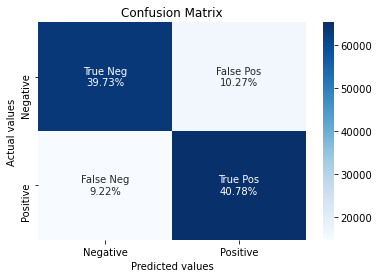

In [195]:
LRmodel = LogisticRegression(max_iter = 1000, C = 2, n_jobs=-1)
LRmodel.fit(x_train, y_train)

evaluate(LRmodel)

## LinearSVC

Accuracy Score : 79.12% 

Classification Report : 

               precision    recall  f1-score   support

           0       0.80      0.78      0.79     80000
           1       0.78      0.80      0.79     80000

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



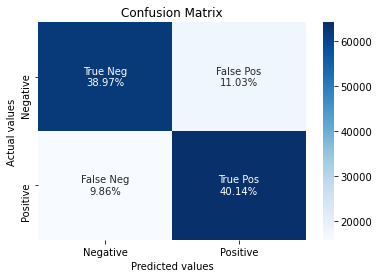

In [196]:
SVC_lr = LinearSVC()
SVC_lr.fit(x_train, y_train)

evaluate(SVC_lr)